Base: C:\Users\riley\PycharmProjects\processamento_imagems
Imgs : 60
Masks: 60
Labelmap carregado:
  background -> (0, 0, 0)
  bridge     -> (184, 61, 245)
  ruler      -> (250, 125, 187)
  water      -> (170, 240, 209)

Visualizando par 1: ezgif-frame-002.png


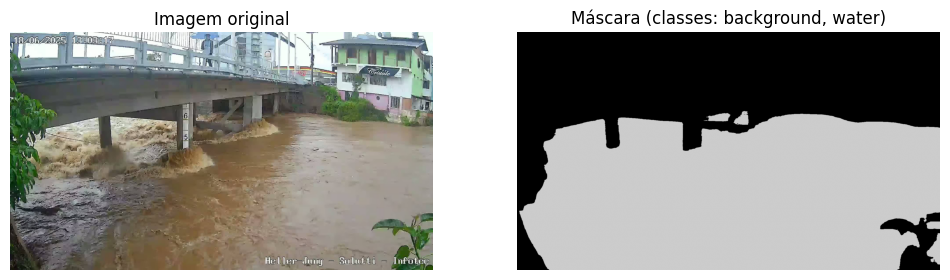


Visualizando par 2: ezgif-frame-003.png


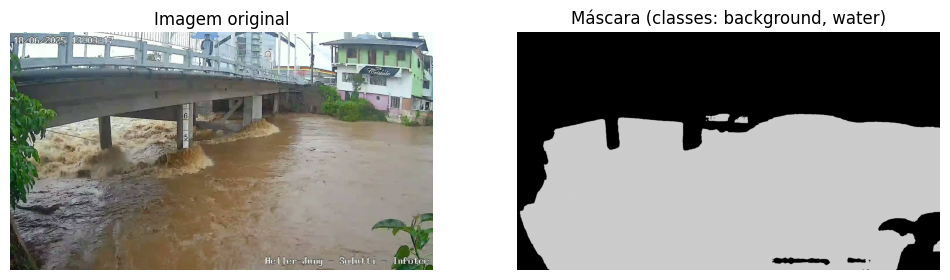

In [1]:
import os
import json
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt


from pathlib import Path

IMG_DIR = Path("dataset/img")

for img_path in IMG_DIR.glob("*.jpg.png"):
    new_name = img_path.name.replace(".jpg.png", ".png")
    new_path = img_path.with_name(new_name)
    print(f"{img_path.name}  ->  {new_path.name}")
    img_path.rename(new_path)


plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = False
SEED = 42
np.random.seed(SEED)

BASE = Path.cwd()
DATASET = BASE / "dataset"
IMG_DIR = DATASET / "img"
MASK_DIR = DATASET / "mask"
LABELMAP_PATH = DATASET / "labelmap.txt"

print("Base:", BASE)
print("Imgs :", len(list(IMG_DIR.glob('*'))))
print("Masks:", len(list(MASK_DIR.glob('*'))))

# ===============================
# Leitura do labelmap
# ===============================
def load_labelmap(labelmap_path: Path):
    labelmap = {}
    with open(labelmap_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or ":" not in line:
                continue
            name, rest = line.split(":", 1)
            rgb = rest.split(":")[0]
            rgb = rgb.strip()
            if not rgb:
                continue
            try:
                r, g, b = map(int, rgb.split(","))
                labelmap[(r, g, b)] = name.strip()
            except ValueError:
                pass
    return labelmap

# ===============================
# Funções utilitárias
# ===============================
def rgb_mask_to_index(mask_rgb: np.ndarray, labelmap: dict) -> np.ndarray:
    """
    Converte uma máscara RGB (colorida) em matriz de índices de classe.
    Cada pixel RGB é comparado com o dicionário labelmap.
    """
    h, w, _ = mask_rgb.shape
    mask_index = np.zeros((h, w), dtype=np.uint8)
    for i, (rgb, name) in enumerate(labelmap.items()):
        color = np.array(rgb, dtype=np.uint8)
        match = np.all(mask_rgb == color, axis=-1)
        mask_index[match] = i
    return mask_index

def show_image_and_mask(img_path: Path, mask_path: Path, labelmap: dict):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_rgb = cv2.imread(str(mask_path))
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    mask_index = rgb_mask_to_index(mask_rgb, labelmap)

    unique_vals = np.unique(mask_index)
    colors = np.array(list(labelmap.keys())) / 255.0
    names = list(labelmap.values())

    # Visualização
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagem original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_index, cmap="nipy_spectral")
    plt.title(f"Máscara (classes: {', '.join([names[i] for i in unique_vals])})")
    plt.axis("off")
    plt.show()

# ===============================
# Visualização das duas primeiras
# ===============================
all_imgs = sorted(IMG_DIR.glob("*.png"))
all_masks = sorted(MASK_DIR.glob("*.png"))

# --- carregar o labelmap antes de usar ---
labelmap = load_labelmap(LABELMAP_PATH)
print("Labelmap carregado:")
for rgb, name in labelmap.items():
    print(f"  {name:<10} -> {rgb}")


if len(all_imgs) >= 2 and len(all_masks) >= 2:
    for i in range(2):
        print(f"\nVisualizando par {i+1}: {all_imgs[i].name}")
        show_image_and_mask(all_imgs[i], all_masks[i], labelmap)
else:
    print("Verifique se existem pelo menos 2 imagens e 2 máscaras nas pastas correspondentes.")


Dataset carregado:
  X shape: (60, 512, 512, 3), dtype=float32
  y shape: (60, 512, 512), dtype=uint8
  Train: 48, Val: 12


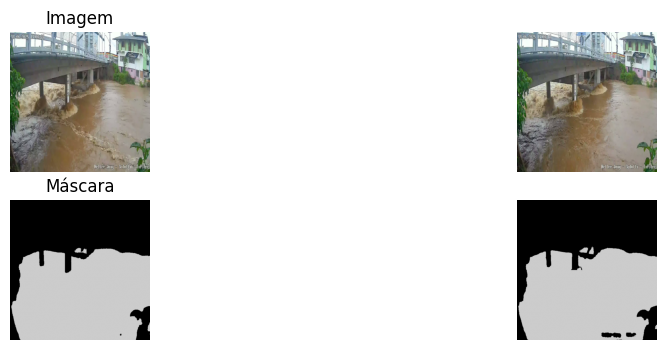

In [2]:
from sklearn.model_selection import train_test_split
# alteração dependendo do resultado bom ou ruim

IMG_SIZE = (512, 512)
TEST_RATIO = 0.2

def load_dataset(img_dir: Path, mask_dir: Path, labelmap: dict, target_size=(256, 256)):
    imgs, masks = [], []
    color_to_idx = {rgb: i for i, rgb in enumerate(labelmap.keys())}

    img_paths = sorted(img_dir.glob("*.png"))
    for img_path in img_paths:
        mask_path = mask_dir / img_path.name
        if not mask_path.exists():
            continue

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0

        mask_rgb = cv2.imread(str(mask_path))
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.resize(mask_rgb, target_size, interpolation=cv2.INTER_NEAREST)

        mask_idx = np.zeros(target_size, dtype=np.uint8)
        for i, (rgb, _) in enumerate(labelmap.items()):
            match = np.all(mask_rgb == np.array(rgb, dtype=np.uint8), axis=-1)
            mask_idx[match] = i

        imgs.append(img)
        masks.append(mask_idx)

    X = np.stack(imgs, axis=0)
    y = np.stack(masks, axis=0)
    return X, y

X, y = load_dataset(IMG_DIR, MASK_DIR, labelmap, IMG_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_RATIO, random_state=SEED)

print(f"Dataset carregado:")
print(f"  X shape: {X.shape}, dtype={X.dtype}")
print(f"  y shape: {y.shape}, dtype={y.dtype}")
print(f"  Train: {len(X_train)}, Val: {len(X_val)}")

def plot_samples(X, y, n=3):
    n = min(n, len(X))
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(X[i])
        plt.axis("off")
        if i == 0:
            plt.title("Imagem")

        plt.subplot(2, n, n + i + 1)
        plt.imshow(y[i], cmap="nipy_spectral")
        plt.axis("off")
        if i == 0:
            plt.title("Máscara")
    plt.show()

plot_samples(X_train, y_train, n=2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[

 Total params: 1,952,612 (7.45 MB)

 Trainable params: 1,949,796 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9417 - loss: 0.2183 - val_accuracy: 0.5618 - val_loss: 6.3884
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9835 - loss: 0.0643 - val_accuracy: 0.5618 - val_loss: 4.9467
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9864 - loss: 0.0491 - val_accuracy: 0.5618 - val_loss: 4.8973
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9880 - loss: 0.0437 - val_accuracy: 0.5618 - val_loss: 5.2671
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9865 - loss: 0.0489 - val_accuracy: 0.5620 - val_loss: 5.4548
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9862 - loss: 0.0480 - val_accuracy: 0.5624 - val_loss: 5.5655
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9884 - loss: 0.0397 - val_accuracy: 0.6252 - val_loss: 4.1641
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9893 - loss: 0.0354 - val_accuracy: 0.6921 - v

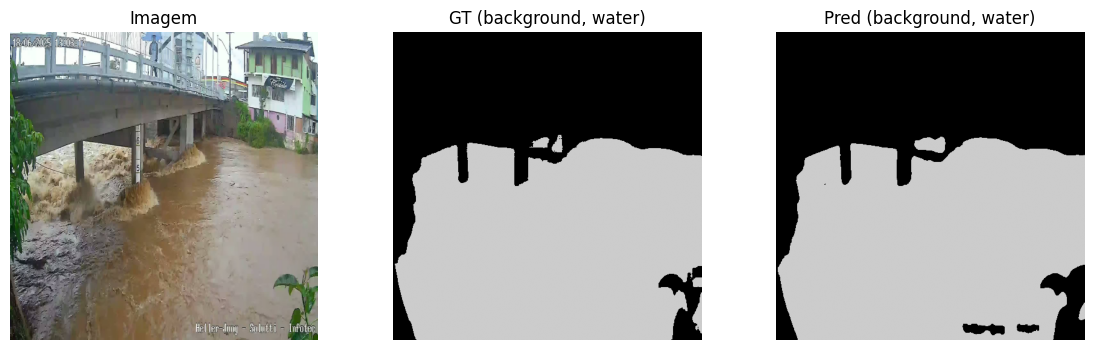

IoU por classe: {'background': 0.9672499530067075, 'bridge': 0.0, 'ruler': 0.0, 'water': 0.9742646318291316}
Modelo salvo em unet_small_segmentation.keras
IoU (train) por classe:
{'background': 0.966, 'bridge': 0.0, 'ruler': 0.0, 'water': 0.979}
IoU (val) por classe:
{'background': 0.972, 'bridge': 0.0, 'ruler': 0.0, 'water': 0.978}


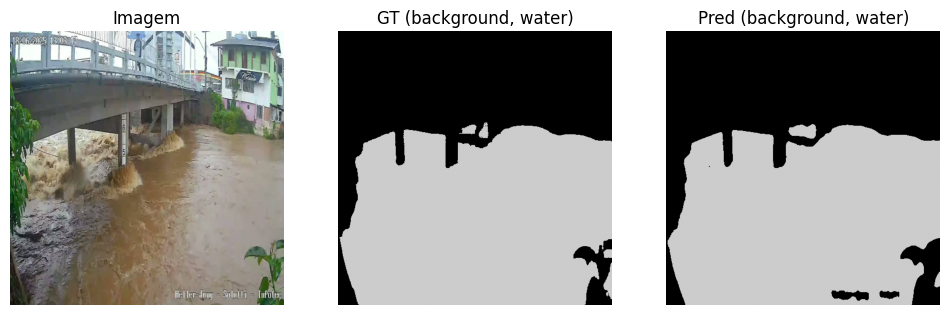

[train 0] régua/água não detectadas para estimar nível.
[train 1] régua/água não detectadas para estimar nível.
[train 2] régua/água não detectadas para estimar nível.
[train 3] régua/água não detectadas para estimar nível.
[train 4] régua/água não detectadas para estimar nível.
[train 5] régua/água não detectadas para estimar nível.
[train 6] régua/água não detectadas para estimar nível.
[train 7] régua/água não detectadas para estimar nível.
[train 8] régua/água não detectadas para estimar nível.
[train 9] régua/água não detectadas para estimar nível.
[train 10] régua/água não detectadas para estimar nível.
[train 11] régua/água não detectadas para estimar nível.
[train 12] régua/água não detectadas para estimar nível.
[train 13] régua/água não detectadas para estimar nível.
[train 14] régua/água não detectadas para estimar nível.
[train 15] régua/água não detectadas para estimar nível.
[train 16] régua/água não detectadas para estimar nível.
[train 17] régua/água não detectadas para

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

NUM_CLASSES = len(labelmap)          # background, bridge, water, ruler
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_small(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64);     p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128);    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    bn = conv_block(p3, 256)

    # Decoder
    u3 = layers.UpSampling2D()(bn); u3 = layers.Concatenate()([u3, c3]); c4 = conv_block(u3, 128)
    u2 = layers.UpSampling2D()(c4); u2 = layers.Concatenate()([u2, c2]); c5 = conv_block(u2, 64)
    u1 = layers.UpSampling2D()(c5); u1 = layers.Concatenate()([u1, c1]); c6 = conv_block(u1, 32)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c6)
    return keras.Model(inputs, outputs)

model = unet_small(INPUT_SHAPE, NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.summary()

# Datasets para o Keras (y precisa shape (H,W,1) para SparseCategoricalCrossentropy)
y_train_exp = y_train[..., np.newaxis]
y_val_exp   = y_val[..., np.newaxis]

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train_exp,
    validation_data=(X_val, y_val_exp),
    epochs=100,               # com 2 amostras, vai overfitar rápido; early stopping segura
    batch_size=1,
    verbose=1,
    callbacks=callbacks
)

# Predição de inspeção
def visualize_pred(img, mask_true, mask_pred_idx, names=None):
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Imagem"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask_true, cmap="nipy_spectral");
    t = "GT"
    if names is not None:
        uniques = np.unique(mask_true); t += " (" + ", ".join([names[i] for i in uniques]) + ")"
    plt.title(t); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask_pred_idx, cmap="nipy_spectral");
    t = "Pred"
    if names is not None:
        uniques = np.unique(mask_pred_idx); t += " (" + ", ".join([names[i] for i in uniques]) + ")"
    plt.title(t); plt.axis("off")
    plt.show()

# Faz uma predição no primeiro item do conjunto de validação
names = list(labelmap.values())
pred = model.predict(X_val[:1])[0]            # (H,W,C)
pred_idx = np.argmax(pred, axis=-1)           # (H,W)

visualize_pred(X_val[0], y_val[0], pred_idx, names=names)

# Métrica simples de IoU por classe (apenas para referência rápida)
def iou_per_class(y_true, y_pred, num_classes):
    ious = []
    for c in range(num_classes):
        t = (y_true == c)
        p = (y_pred == c)
        inter = np.logical_and(t, p).sum()
        union = np.logical_or(t, p).sum()
        iou = inter / (union + 1e-9)
        ious.append(iou)
    return ious

ious = iou_per_class(y_val[0], pred_idx, NUM_CLASSES)
print("IoU por classe:", {names[i]: float(ious[i]) for i in range(NUM_CLASSES)})

# Salvar pesos (opcional)
model.save("unet_small_segmentation.keras")
print("Modelo salvo em unet_small_segmentation.keras")

# ===============================================
# Parte 4 — Avaliação: IoU por classe + nível d’água (px)
# ===============================================

import numpy as np
import matplotlib.pyplot as plt

# nomes de classes na ordem do labelmap carregado
CLASS_NAMES = list(labelmap.values())  # ex.: ['background','bridge','ruler','water']
NUM_CLASSES = len(CLASS_NAMES)

def predict_masks(model, X):
    """Retorna máscaras indexadas (argmax) a partir de probabilidades do modelo."""
    probs = model.predict(X, verbose=0)   # (N,H,W,C)
    return np.argmax(probs, axis=-1)      # (N,H,W)

def iou_per_class_batch(y_true, y_pred, num_classes):
    """IoU por classe, agregando sobre o batch."""
    ious = []
    for c in range(num_classes):
        t = (y_true == c)
        p = (y_pred == c)
        inter = np.logical_and(t, p).sum()
        union = np.logical_or(t, p).sum()
        iou = inter / (union + 1e-9)
        ious.append(float(iou))
    return ious

def visualize_triplet(img, y_true_idx, y_pred_idx, names=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Imagem"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(y_true_idx, cmap="nipy_spectral");
    if names is not None:
        labs = ", ".join({names[i] for i in np.unique(y_true_idx)})
        plt.title(f"GT ({labs})")
    plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(y_pred_idx, cmap="nipy_spectral");
    if names is not None:
        labs = ", ".join({names[i] for i in np.unique(y_pred_idx)})
        plt.title(f"Pred ({labs})")
    plt.axis("off")
    plt.show()

def measure_water_level_px(mask_idx, class_names):
    """
    Estima o nível d'água em pixels: pega a bbox da régua e,
    dentro do intervalo [x1,x2], encontra a menor coordenada y
    onde aparece 'water' (ou a transição topo da água) e tira a média.
    Retorna (y_medio, bbox_ruler).
    """
    # identifica índices das classes
    try:
        idx_ruler = class_names.index("ruler")
    except ValueError:
        # fallback para nomes alternativos
        idx_ruler = class_names.index(next(n for n in class_names if "ruler" in n))
    try:
        idx_water = class_names.index("water")
    except ValueError:
        idx_water = class_names.index(next(n for n in class_names if "water" in n))

    H, W = mask_idx.shape
    ruler_mask = (mask_idx == idx_ruler)
    water_mask = (mask_idx == idx_water)

    # bbox da régua
    ys, xs = np.where(ruler_mask)
    if len(xs) == 0:
        return None, None  # régua não encontrada
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()

    # dentro das colunas da régua, achar a "linha" mais alta de água
    # estratégia: para cada coluna no range [x1,x2], pegar o menor y onde há água
    y_candidates = []
    for x in range(x1, x2+1):
        col = water_mask[:, x]
        ys_water = np.where(col)[0]
        if len(ys_water) > 0:
            y_candidates.append(ys_water.min())

    if not y_candidates:
        return None, (x1,y1,x2,y2)

    y_level = int(np.mean(y_candidates))  # média robusta do topo da água
    return y_level, (x1,y1,x2,y2)

# ---- Executa avaliação em train e val ----
pred_train = predict_masks(model, X_train)
pred_val   = predict_masks(model, X_val)

ious_train = iou_per_class_batch(y_train, pred_train, NUM_CLASSES)
ious_val   = iou_per_class_batch(y_val,   pred_val,   NUM_CLASSES)

print("IoU (train) por classe:")
print({CLASS_NAMES[i]: round(ious_train[i], 3) for i in range(NUM_CLASSES)})
print("IoU (val) por classe:")
print({CLASS_NAMES[i]: round(ious_val[i], 3) for i in range(NUM_CLASSES)})

# visualização rápida do primeiro item de validação
visualize_triplet(X_val[0], y_val[0], pred_val[0], names=CLASS_NAMES)

# mede nível d'água nos dois conjuntos (quando possível)
for tag, Xsplit, ypred in [("train", X_train, pred_train), ("val", X_val, pred_val)]:
    for i in range(len(Xsplit)):
        y_level, bbox = measure_water_level_px(ypred[i], CLASS_NAMES)
        if y_level is None:
            print(f"[{tag} {i}] régua/água não detectadas para estimar nível.")
            continue
        print(f"[{tag} {i}] nível d'água (px, eixo y-top=0): {y_level}, bbox_ruler={bbox}")
